# Interior Object Recommendation System in Latent Space

Team Member: Bill Chen (gc2677), Nana Takada (nt2483)

This is our main file. We also have a experiment file, which contains VAE and VGG19 with Flickr, Pinterest Dataset, as well as Tensorboard results. 

Presentation of this project is here as an unlisted youtube video:
https://youtu.be/42E5XnMkns8


## Project Goals
The goal of the project is to see if we can somehow recommend interior room products from an image of a room. The idea is that we can somehow extract
style information from a room and products and to see what sort matching occurs in some sort of latent style space, we can make a recommendation system that is
mostly unsupervised and does not require any sort of user information other than an image of the room. The difficulty in this is to extract latent space
There are some existing work on using image segmentation, topic modeling (LDA etc) ([link](http://vision.cs.utexas.edu/projects/StyleEmbedding/ "style embedding"))  to accomplish such things in the fashion industry. However, all of these require
well labeled data to train and we are here to see if twe can make something close without having such high quality data.

## Dataset
In our project, we used two kinds of dataset: 1. room images with different styles and 2. paired data of room image and object image.
Link to access the dataset: https://drive.google.com/drive/folders/1Q5Iro44c5Y_Ipw0iUoc0OJjmzQNrdTpL?usp=sharing

1. Differnt styles room images dataset are used to see if different styles are captured and clustered in the similar region in the latent space. 
    1. We scapred from iamges from iStock with name of "Japanese room with no people", "Modern room with no people, and "Scnadinavian room with no people". Some of the data are not necesarily the best as interior room picture; however, most are considered well. I scapred approximately 1,000 images from each category. (iStock_data.zip: https://drive.google.com/file/d/1-fVFGaVl3Zw_kpsUSyGdTL1SZClFQCp8/view?usp=sharing)
    2. We used LSUN/living-room data to train our variational autoencoder and is downloaded through tensorflow datasets
    3. We also used images from Flickr to test VAE: (https://drive.google.com/drive/folders/1kFDxFuNELA3ag3bHCpQoCSAy0-2pUrOS?usp=sharing) 
        Interestingly, Flickr dataset of Japanese, western images and iStock dataset produces slightly different results. This is due to we used Tatami, and western images from Flickr, but from iStock, we used Japanese, western, and scandinavian room images. The Flickr images have more distrinct differeneces compared to those of iStock. 



2. Second dataset is used to test model's accuracy by calculating number of room images with correct object recommendation. MADE has images of rooms and objects mostly from either scandinacian, classic, modern, and any other western style objects or rooms. Thus, although there are supposed to be a style differnece, detection might be difficult even with human eyes. I scapred 100 objects and around 1000 room images for trainig. More than 1 room can fit with a object. For testing, I scraped 50 objects. (MADE_data.zip: https://drive.google.com/file/d/1iWRCes8QH3vMwt_yoit5TRX2rJwyL_TC/view?usp=sharing)

## Different Methods We tested: 
We tested various methods which projects images into a good latent space, that paired object and room will be in the similar space in the latent space. 

1. Autoencoder / Autoencoder + Dense Layer
2. Variational Autoencoder 
3. Style Layers from VGG16 
4. VGG16 + PCA 
5. VGG16 + Random Projection 
6. VGG16 + Random Projection + Dense Layer  
7. VGG16 + Random Projection + Room->Room, Obj->Obj

First, we tested with Autoencoder as well as Variatoinal Autoencoder. We used the embeddings produced by encoder, hoping it gives a some latent space. For AE, I found out AE does not necessarily cluster different styles in TSNE projection. However, it might be due to the resembleness of different styles I used (You can see some examples images below.) Also, we found out room and object images are projected in the diffrent space in the latent space. It is likely due to the different background color of the images. Most of the objects have white backgrounds, but for most of the room images do not have white backgrounds. Becasue room images and object images are projected in the different region, the recommendations' accuracy was low, which is sometimes worse than random recommendations. Since we pick recommendations using KNN, and images and room are projected in the different place, the object images that are closed to the room cluster are always recommended. We concluded the object that does not have a white background is always the top of recommendations. Since it recommends the same image, the accuracy sometime is lower than the randome recommendation. 

Thus, we made a model with Dense Layers with inputs of room embeddings and output as paired object embeddings, so room embeddings and objects embeddings will be aligned in the similar space. This dense layer requires more than 20 epochs, and since Autoencoder's embeddings have too big size, 20,000, we decided to stop this experiment due to its memory exhaustion. 

We also attempted to regularize the latent space with variational autoencoder, hoping that it would smooth out the latent space and lead to better embedding and recommendations.  However, the result was similar with AE. It has the similar problem of skewed recommendations by having rooms and obejcts projected in the different space. The accuracy was 19.1%. 

Thus, we moved on to a new model idea. We then tried to use the intermediate layers outputs from pretrained VGG19 network and calculate the gram matrix and flatten it, so that we obtain a vector of the inner product space of all the intermediate filter outputs, which encapsulate how each filter correlates with one another, which was how neural style transfer was done ([link](https://www.tensorflow.org/tutorials/generative/style_transfer "style_transfer")). The flattened vector is actually 600k dimensions large which we had to randomly project down to 500 dims due to computational and spacial constraints. We elected to use random projection because it is simple and elegant and other methods such as PCA also need a very large computation overhead. Random project works because the interpoint distances are relatively well preserved owing to the Johnson-Lindenstrauss lemma ([link](http://cseweb.ucsd.edu/~dasgupta/papers/jl.pdf "johnson-lindenstrauss")).

With the method, we tried three different systems. 
1. Pure Recommendations: Using the embeddings after the random projection, I tested weather different styles will be clustered. Based on TSNE, different styles were not necessaily clustered. However, I could observe Japanese images are embedded slighty outside of modern/scandinavian styles. Although, we would like to see different styles are projected differently, so recommendations would be more accurate, we acknowlegd that they do not necessarily need to locate in the differnt spaces since styles do not have clear differences.Then, I calculated the accuracy of recommendations. And we achieved 29.8%. The embeddings with VGG+Random Projection still has the similar problem with AE and VAE, which room and images are projected in the different space. Thus, we tried two methods. 
2. Room-> Room & Obj-> Obj Method: Basically, 1) we find the closest room image (A) of the input image (I) in the latent space. 2) We find the obj (O) which is paired with the closes room image (A). 3) Then, we find the KNN objects (K1,K2,K3...) of the obj (O). This way, we managed to solve the problem of rooms and objects are not projected in the similar area. The result was 33%, which is a great improvement from 20%. The problem is sometimes the the correct obj (C), paired with (I), is sofa, but the all O, K1, K2, K3.. are lamps, sicne O is lamp. This results in a low accuracy. In future works, we can solve this problem by instead of finding only the closes room (A), we can find 2 or more closes rooms (A1, A2,...). In this way, we can solve the problem of only the one tyle of object is recommended. 
3. Adding Dense Layer: We made a new model with dense layers which takes a input of room embeddings and output of obj embeddings. In this way, we can align two clusters in the similar region. This one gives a result of 30%. 

In summary, Room-> Room & Obj-> Obj has the best accuracy. 

We can potentially improve our model using Contrastive learning. 

## Result
AE performed the poorest with top 10 accuracy of 20.8%. VAE at 19.1%. Using VGG19's style extractor, we achieved a top 10 accuracy rate of 30% as compared to 20% in random guess top 10 accuracy. room->room obj->obj does best at 33.5%

We tested with top 10 recommendations. Since we have 50 images in the testing objects photo, the random projection would be about 20%. 
1. AE: 20.8%
2. VAE: 19.1% 
3. VGG Styla extractor 29.8% 
4. VGG + Room to Room, Obj to Obj: 33%
4. VGG + Dense Layer 28.6% 

## Next Step:
contrastive learning can be potentially a better approach due to it actually cropping into different parts of the image and learns the correlation between potential details of the room that will result in an object fitting or not. This can be future work.

## This notebook's index: 
1. Libraries 
2. Dataset
    1. scraping from MADE (Paired data) 
    2. Scrapign from iStock (Different style room data)
3. Autoencoder 
    1. Build an Autoencoder
    2. Test different styles are clustered 
    3. Test Recommendation model's accuracy  
    4. Add Dense Layer 
4. VAE
    1. Build a VAE 
    2. Test Recommendations model's accuracy 
5. VGG19 Style Extractor
    1. Build a style extracotr Model 
    2. Add Random Projection  
    3. Test different styles are clustered 
    4. Room->Room&Obj->Obj
        1. Test accuracy 
    5. Add Dense Layer
        1. Test accuracy
    
    
## Bibliography
- https://www.dataquest.io/blog/web-scraping-beautifulsoup/
- https://www.tensorflow.org/tutorials/generative/autoencoder
- http://vision.cs.utexas.edu/projects/StyleEmbedding/
- http://www.iri.upc.edu/files/scidoc/1904-Multi-Modal-Joint-Embedding-for-Fashion-Product-Retrieval.pdf
- https://idl.cs.washington.edu/files/2019-LatentSpaceCartography-EuroVis.pdf
- https://www.ijcai.org/Proceedings/2019/0745.pdf
- https://www.youtube.com/watch?v=PH_StUlTSKE&ab_channel=TAUVOD
- https://arxiv.org/pdf/1801.03002.pdf
- https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
    
 

## Libraries 

In [3]:
from bs4 import BeautifulSoup
import requests
import urllib.request
import shutil
import numpy as np
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import random
import shutil
import time
import glob
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import csv

## Dataset

### Scraping Paired Data from MADE
I collected paired data from website called MADE. MADE is an interior objects marketplace, and they have data of paired room and object. I collected 1,000 objects. Since more than 1 room can match with 1 object, the number of room images are more than the number of object images. 

The below code scrape room, obj, test_room, and test_obj images. The information of pairing is stored in the room_obj.txt file. 

MADE: https://www.made.com/room-ideas/

In [275]:
# I refered some codes from https://www.dataquest.io/blog/web-scraping-beautifulsoup/
def scrapeFromMade(num_page, room_name, obj_name):
    drive_root = ''
    room_item= []
    size = 299, 299

    # If directories to store room, obj, test_room, test_obj do not exist, it creates. 
    room_dir = os.path.join(drive_root, "room")
    print("Checkpoints directory is", room_dir)
    if os.path.exists(room_dir):
        print("Checkpoints folder already exists")
    else:
        print("Creating a checkpoints directory")
        os.makedirs(room_dir)

    obj_dir = os.path.join(drive_root, "obj")
    print("Checkpoints directory is", obj_dir)
    if os.path.exists(obj_dir):
        print("Checkpoints folder already exists")
    else:
        print("Creating a checkpoints directory")
        os.makedirs(obj_dir)

    test_room_dir = os.path.join(drive_root, "test_room")
    print("Checkpoints directory is", test_room_dir)
    if os.path.exists(test_room_dir):
        print("Checkpoints folder already exists")
    else:
        print("Creating a checkpoints directory")
        os.makedirs(test_room_dir)

    test_obj_dir = os.path.join(drive_root, "test_obj")
    print("Checkpoints directory is", test_obj_dir)
    if os.path.exists(test_obj_dir):
        print("Checkpoints folder already exists")
    else:
        print("Creating a checkpoints directory")
        os.makedirs(test_obj_dir)
    obj_num = 0
    room_num = 0
    obj_url= []

    url = "https://www.made.com/room-ideas/?page={}".format(num_page)
    image_info = []
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    aas = soup.find_all("div", class_='styles__ImageCardElement-sc-128pnh5-0 iWUzDA')

    for a in aas:
        if obj_num == 100: 
            obj_dir = test_obj_dir
            room_dir = test_room_dir
        if obj_num > 150: 
            return obj_num, room_num, room_item
        print("obj",obj_num)
        response = requests.get(a.a["href"])
        soup = BeautifulSoup(response.text, "html.parser")
        obj = soup.find_all("img", class_= 'ResponsiveImage__Image-sc-1oncuu5-0 jVZbjE')
        if len(obj)==0:
            continue
        try:
            obj = obj[1]["src"]
        except: 
            continue
        if obj in obj_url:
            continue
        obj_url.append(obj)
        response = requests.get(obj, stream=True)


        obj_filename = obj_dir+"/{}.jpg".format(obj_num)
        obj_num += 1
        file = open(obj_filename, 'wb')
        response.raw.decode_content = True
        shutil.copyfileobj(response.raw, file)
        del response

        aas = soup.find_all("img", class_='ResponsiveImage__Image-wcqeml-0 eVWtqR')

        for image in aas:
            response = requests.get(image["src"], stream=True)
            room_filename = room_dir+"/{}.jpg".format(room_num)
            file = open(room_filename, 'wb')
            response.raw.decode_content = True
            shutil.copyfileobj(response.raw, file)
            room_num +=1
            del response
            room_item.append([obj_filename,room_filename])


In [37]:
# Scraping 100 objects
obj_num, room_num, room_item = scrapeFromMade(100, "room", "obj")

Checkpoints directory is room
Creating a checkpoints directory
Checkpoints directory is obj
Creating a checkpoints directory
Checkpoints directory is test_room
Creating a checkpoints directory
Checkpoints directory is test_obj
Creating a checkpoints directory
obj 0
obj 1
obj 2
obj 3
obj 3
obj 3
obj 4
obj 5
obj 6
obj 7
obj 7
obj 7
obj 8
obj 9
obj 10
obj 11
obj 12
obj 13
obj 14
obj 15
obj 16
obj 17
obj 17
obj 18
obj 18
obj 19
obj 19
obj 20
obj 20
obj 21
obj 22
obj 22
obj 23
obj 23
obj 23
obj 24
obj 24
obj 25
obj 25
obj 25
obj 26
obj 27
obj 28
obj 28
obj 29
obj 30
obj 31
obj 32
obj 33
obj 33
obj 34
obj 35
obj 36
obj 37
obj 38
obj 38
obj 40
obj 40
obj 40
obj 40
obj 40
obj 41
obj 42
obj 43
obj 43
obj 44
obj 45
obj 46
obj 47
obj 48
obj 49
obj 50
obj 51
obj 52
obj 53
obj 53
obj 54
obj 55
obj 56
obj 57
obj 58
obj 58
obj 58
obj 59
obj 60
obj 61
obj 62
obj 63
obj 64
obj 65
obj 65
obj 66
obj 67
obj 68
obj 69
obj 70
obj 71
obj 72
obj 73
obj 74
obj 75
obj 76
obj 76
obj 76
obj 76
obj 77
obj 77
obj 7

In [39]:
# Store paired data into room_obj file
with open('room_obj.txt', 'w') as f:
    for room, obj in room_item:
        f.write(str(room)+","+str(obj)+"\n")

### Scraping Different Style Room Images from iStock

I collected modern, scandinavian, and japanese styles room pictures from iStock. 
Some of the pictures from iStock have outside images or human. 

iStock: https://www.istockphoto.com/photos/living-room?istockcollection=&mediatype=photography&phrase=living%20room&sort=best

In [295]:
# I refered some codes from https://www.dataquest.io/blog/web-scraping-beautifulsoup/
def scrape_from_istock(url_front, url_end):
    image_info = []
    for i in range(20):
        url = url_front  +str(i)+url_end
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        aas = soup.find_all("img", class_='gallery-asset__thumb gallery-mosaic-asset__thumb')
        for a in aas:
            image_info.append(a["src"])
    print(len(image_info))
    return image_info

In [282]:
# Based on URLs collected, the download_image downloads images into the folder passed in the parameter
def download_image(image,i, folder):
    response = requests.get(image, stream=True)
    realname = "interior"+str(i)
    
    file = open("./{}/{}.jpg".format(folder, realname), 'wb')
    
    response.raw.decode_content = True
    shutil.copyfileobj(response.raw, file)
    del response

In [283]:
# Scraping modern room images
url_front = "https://www.istockphoto.com/photos/modern-living-room-with-no-people?istockcollection=&mediatype=photography&page="
url_end = "&phrase=modern%20living%20room%20with%20no%20people&sort=best"
image_info = scrape_from_istock(url_front, url_end)

1140


In [122]:
!mkdir ./modern_interior

mkdir: cannot create directory ‘./modern_interior’: File exists


In [293]:
#download images of modern interior 
for i in range(0, len(image_info)):
    download_image(image_info[i],i, 'modern_interior')

In [327]:
#Scraping Japense room images
# https://www.istockphoto.com/search/more-like-this/1141445852?assettype=image&family=creative&istockcollection=&mediatype=photography&page=2&phrase=japanese%20style%20room%20with%20no%20people

url_front= "https://www.istockphoto.com/search/more-like-this/1141445852?assettype=image&family=creative&istockcollection=&mediatype=photography&page="
url_end= "&phrase=japanese%20style%20room%20with%20no%20people"
image_info = scrape_from_istock(url_front,url_end)

944


In [ ]:
!mkdir ./japanese_interior

In [328]:
for i in range(0, len(image_info)):
    download_image(image_info[i],i, 'japanese_interior')

In [299]:
#Scraping scandinavian room images
url_front = "https://www.istockphoto.com/photos/scandinavian-room-with-no-people?istockcollection=&mediatype=photography&page="
url_end = "&phrase=scandinavian%20room%20with%20no%20people&sort=best"
image_info = scrape_from_istock(url_front,url_end)

1140


In [ ]:
!mkdir ./scandinavian_interior

In [300]:
for i in range(0, len(image_info)):
    download_image(image_info[i],i, 'scandinavian_interior')

## Autoencoder

### Build an Autoencoder

In [10]:
# I refered some code from : https://www.tensorflow.org/tutorials/generative/autoencoder
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(100, 100, 3)), 
          layers.Conv2D(64, (3,3), activation='relu', padding='same'),
          layers.MaxPool2D((2,2),padding='same'),
          layers.Conv2D(32, (3,3), activation='relu', padding='same'),
          layers.MaxPool2D((2,2),padding='same'),
          ])

        self.decoder = tf.keras.Sequential([
          layers.Conv2D(64, (3,3), activation='relu', padding='same'),
          layers.UpSampling2D((2,2)),
          layers.Conv2D(32, (3,3), activation='relu', padding='same'),
          layers.UpSampling2D((2,2)),

          layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

### Test three room styles are clustered in the latent space

#### Data Pipeline: 

Training dataset has 80% of each style dataset, and testing dataset has 20% of each.

In [4]:
#Get all filepaths from each directory
japanese_files = list(glob.glob("./japanese_interior/*.jpg"))
modern_files = list(glob.glob("./modern_interior/*.jpg"))
scandinavian_files = list(glob.glob("./scandinavian_interior/*.jpg"))
#Make training and test dataset
all_dif_style_dataset = japanese_files[0:int(len(japanese_files)*0.8)] + modern_files[0:int(len(modern_files)*0.8)] + scandinavian_files[0:int(len(scandinavian_files)*0.8)]
all_dif_style_dataset_test = japanese_files[int(len(japanese_files)*0.8):] + modern_files[int(len(modern_files)*0.8):] + scandinavian_files[int(len(scandinavian_files)*0.8):]

In [86]:
def show_images(folder):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(10):
        ax = plt.subplot(2, n, i + 1)

        plt.imshow(Image.open(folder[i]))
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#### Sample Images from each category. 

Some images are not necessary perfectly room images. However, each images have descent style components. Also, the difficult part is between moden and scandinavian, I do not clearly see the differences. But I think this is why interior object recommendation is difficult, since some of the styles are really resemble, and people without interior desing backgrund cannot easily tell, 

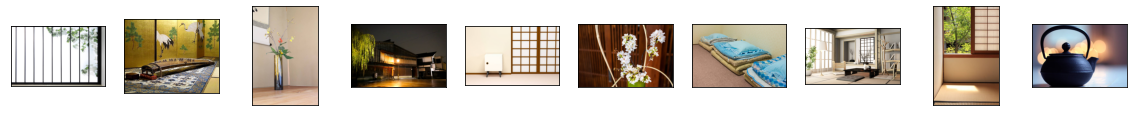

In [11]:
show_images(japanese_files)

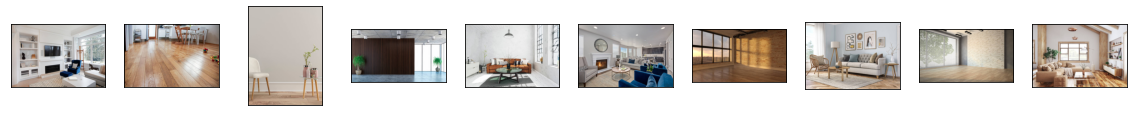

In [12]:
show_images(modern_files)

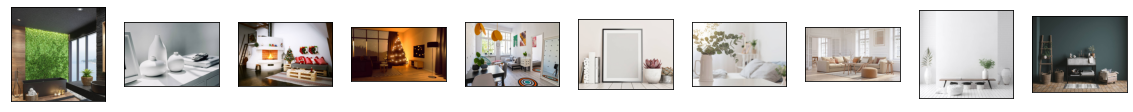

In [333]:
show_images(scandinavian_files)

#### Preprocess Images and make dataset

In [5]:
#read each image and convert them to tesnorflow vectors
#Since it's autoencoder, input and output are both images
IMAGE_SIZE = 100
def image_to_activations(image_path_x, image_path_y):
    img = tf.io.read_file(image_path_x)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img= img/255
    return img, img

In [6]:
all_dif_style_dataset = tf.data.Dataset.from_tensor_slices((all_dif_style_dataset, all_dif_style_dataset))
all_dif_style_dataset_test = tf.data.Dataset.from_tensor_slices((all_dif_style_dataset_test, all_dif_style_dataset_test))

In [7]:
#Map both datasets of filepath to images with resized 100
all_dif_style_dataset = all_dif_style_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)
all_dif_style_dataset_test_ori = all_dif_style_dataset_test.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
# For training set, shuffled and for testing set, leaves as no shuffle.
all_dif_style_dataset = all_dif_style_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
all_dif_style_dataset_test = all_dif_style_dataset_test_ori.batch(BATCH_SIZE)

#### Fit the model

In [12]:
#Fit the dataset to the model
autoencoder.fit(all_dif_style_dataset,validation_data=all_dif_style_dataset_test, epochs=5)

Epoch 1/5
41/41 [==============================] - 54s 1s/step - loss: 0.0394 - val_loss: 0.0181
Epoch 2/5
41/41 [==============================] - 55s 1s/step - loss: 0.0160 - val_loss: 0.0149
Epoch 3/5
41/41 [==============================] - 54s 1s/step - loss: 0.0127 - val_loss: 0.0112
Epoch 4/5
41/41 [==============================] - 55s 1s/step - loss: 0.0107 - val_loss: 0.0098
Epoch 5/5
41/41 [==============================] - 55s 1s/step - loss: 0.0096 - val_loss: 0.0090


In [13]:
test_len = int(len(japanese_files)*0.2) + int(len(modern_files)*0.2)+int(len(scandinavian_files)*0.2)
print(test_len)

644


#### Check each imaeg is decoded correctly

All images are decoded well. Each styles' differences are not necessary clearly from my view point especially on 

In [14]:
test_dataset = all_dif_style_dataset_test_ori.batch(test_len)
test_batch_x, test_batch_y = next(iter(test_dataset))
encoded = autoencoder.encoder(test_batch_x)
decoded = autoencoder.decoder(encoded)

In [15]:
def show_images_from_eachstyle(starting_point):
    n = 10
    plt.figure(figsize=(20, 4))
    orig = starting_point
    for i in range(10):
        ax = plt.subplot(2, n, i + 1)
        plt.title("original")
        plt.imshow(test_batch_x[orig+i])
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed")
        plt.imshow(decoded[orig+i])
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

Japanese Room Images

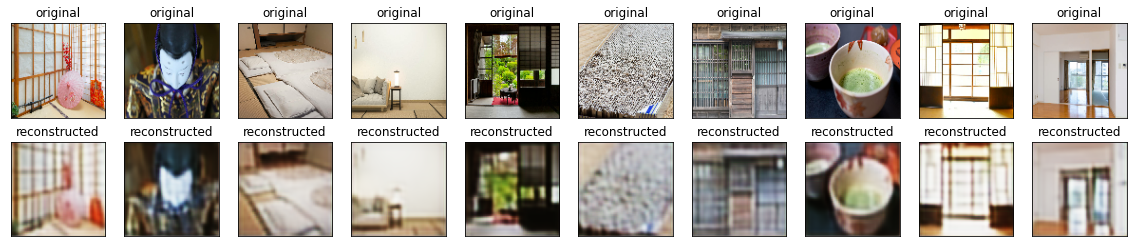

In [16]:
# Japanese st
show_images_from_eachstyle(0)

Modern Room Images

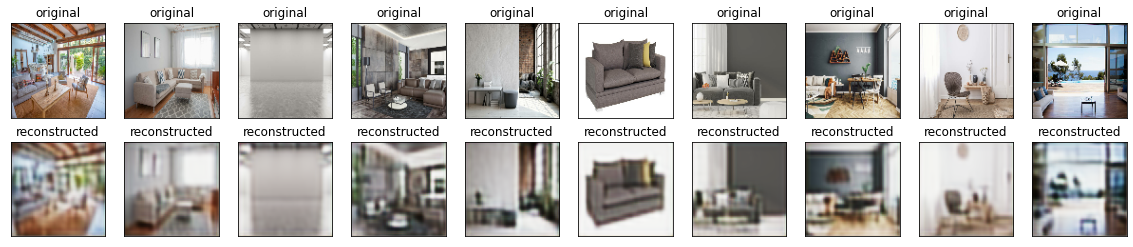

In [17]:
#Modern
show_images_from_eachstyle(int(len(modern_files)*0.2))

Scandinavian Room Images

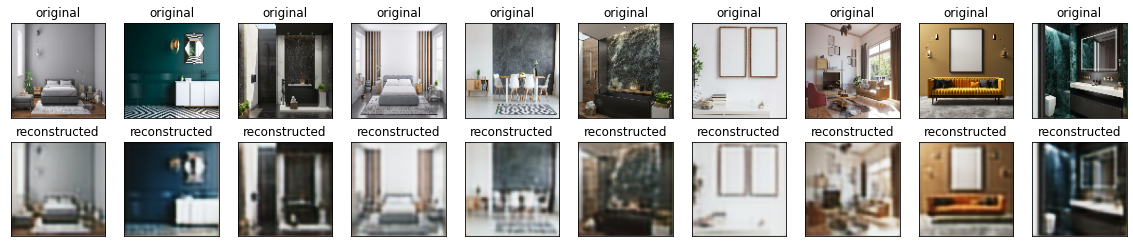

In [16]:
#Scandinavian Images
show_images_from_eachstyle(int(len(modern_files)*0.2)+int(len(scandinavian_files)*0.2))

#### Check if images are clusterd using TSNE

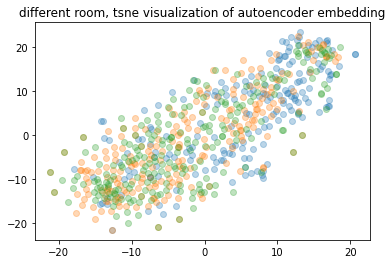

In [17]:
labels = [0] * int(len(japanese_files)*0.2) + [1] * int(len(modern_files)*0.2) + [2]*int(len(scandinavian_files)*0.2)
print()
encoded1 = np.reshape(encoded,(encoded.shape[0],-1))
all_embedded = np.array(encoded1)
visualized = TSNE(n_components=2).fit_transform(all_embedded)
plt.title("different room, tsne visualization of autoencoder embedding")
for label in np.unique(labels):
    plt.scatter(visualized[labels==label][:,0], visualized[labels==label][:,1], label=label, alpha=0.3)
plt.show()

Althogh they are projeected in the similar space, images are not necesasry clustered together. Some potential reasons are each styles are resemble even with human eyes that makes it difficult for model to catch style differences. 

### Test recommendation model's accuracy

Using paired dataset, we train a new autoencoder and test if the model recommends accurately or not.

This time, we use both room and object images assuming paired room and object will be projected in the similar place in the latent space. 

#### Build a new model

In [123]:
# New autoencoder model
autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

#### Data Pipeline, Preprocess Images, Create Dataset

Get data from room, obj, test_room, and test_obj and stored in test_x and train_x. 

In [17]:
# Get dataset of obj and room images from paired dataset
room_ds = list(glob.glob("room/*.jpg"))
obj_ds = list(glob.glob("obj/*.jpg"))
test_room_ds = list(glob.glob("test_room/*.jpg"))
test_obj_ds = list(glob.glob("test_obj/*.jpg"))

In [18]:
train_x = room_ds + obj_ds
test_x = test_room_ds + test_obj_ds

In [19]:
#train_x and test_x has image path
train_x[0]

'room/426.jpg'

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_x))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_x))

In [21]:
train_dataset = train_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)
map_test_dataset = test_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [22]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = map_test_dataset.batch(BATCH_SIZE)

In [23]:
train_batch_x, train_batch_y = next(iter(train_dataset))
print(train_batch_x.shape,train_batch_y.shape)

(64, 100, 100, 3) (64, 100, 100, 3)


#### Sanity Check: Input and output are same images

(64, 100, 100, 3) (64, 100, 100, 3)


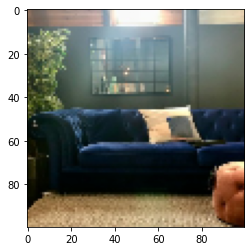

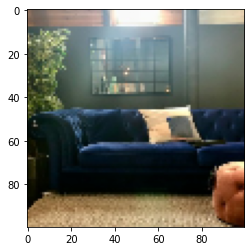

In [24]:
print(train_batch_x.shape, train_batch_y.shape)
plt.imshow(train_batch_x[1])
plt.show()
plt.imshow(train_batch_y[1])
plt.show()

#### Fit the model

In [25]:
autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
20/20 [==============================] - 26s 1s/step - loss: 0.0557 - val_loss: 0.0415
Epoch 2/5
20/20 [==============================] - 26s 1s/step - loss: 0.0294 - val_loss: 0.0251
Epoch 3/5
20/20 [==============================] - 26s 1s/step - loss: 0.0195 - val_loss: 0.0178
Epoch 4/5
20/20 [==============================] - 26s 1s/step - loss: 0.0153 - val_loss: 0.0137
Epoch 5/5
20/20 [==============================] - 26s 1s/step - loss: 0.0124 - val_loss: 0.0122


#### Check autoencoded images

Decoded images look well. 

In [26]:
test_dataset = map_test_dataset.batch(len(test_x))

In [27]:
test_batch_x, test_batch_y = next(iter(test_dataset))
encoded = autoencoder.encoder(test_batch_x)
decoded = autoencoder.decoder(encoded)

In [28]:
print(test_batch_x.shape)

(621, 100, 100, 3)


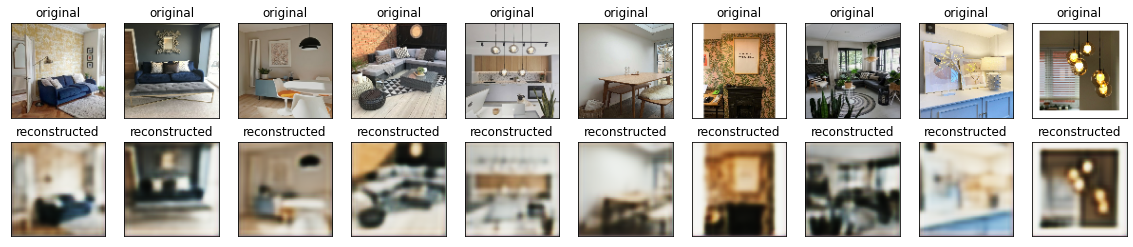

In [29]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(test_batch_x[i])
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(decoded[i])
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

#### Check if obj and room images are in the latent space

In [30]:
labels = [0] * len(test_room_ds) + [1] * len(test_obj_ds) 

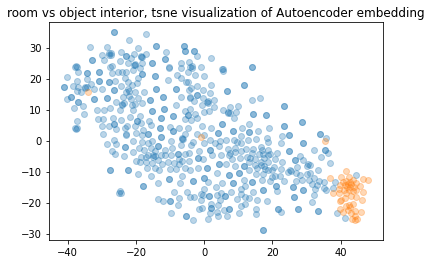

In [31]:
# print(encoded.shape)
encoded1 = np.reshape(encoded,(encoded.shape[0],-1))
all_embedded = np.array(encoded1)
visualized = TSNE(n_components=2).fit_transform(all_embedded)
plt.title("room vs object interior, tsne visualization of Autoencoder embedding")
for label in np.unique(labels):
    plt.scatter(visualized[labels==label][:,0], visualized[labels==label][:,1], label=label, alpha=0.3)
plt.show()

Object and room images are projected differnt space in the latent space. Potential reason is all objects' images have white backgrounds. 

#### Restore room_obj txt and store them into the dictionary: key is room path --> obj image path

In [32]:
with open('./room_obj.txt', newline='') as f:
    reader = csv.reader(f)
    room_item = list(reader)
print(room_item[0])

['obj/0.jpg', 'room/0.jpg']


In [33]:
dic_room_item = {}
for item, key in room_item: 
    dic_room_item[int(key.split("/")[1].split(".")[0])] = int(item.split("/")[1].split(".")[0])
for i in range (20,25):
    print("room {}, obj {}".format(i, dic_room_item[i]))

room 20, obj 1
room 21, obj 1
room 22, obj 1
room 23, obj 1
room 24, obj 1


#### Check Accuracy for the recommendations 

#### Random 10 recommendations accuracy

In [40]:
correct = 0
knn = 10
embededed_room = all_embedded[:len(test_room_ds)]
embededed_obj = all_embedded[len(test_room_ds):]
for i in range(len(test_room_ds)):
    dist_arr =  embededed_obj - embededed_room[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  np.random.permutation(dist_arr.argsort())[:knn]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
    try:
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
        
            correct +=1
    except: 
        continue
            
print("correct images", correct)
print("accuracy of randomly selected {} images: {}".format(knn, correct/len(test_room_ds)))

correct images 119
accuracy of randomly selected 10 images: 0.20877192982456141


#### Autoencoder top 10 recommendations accuracy

In [41]:
correct = 0
embededed_room = all_embedded[:len(test_room_ds)]
embededed_obj = all_embedded[len(test_room_ds):]
for i in range(len(test_room_ds)):
    dist_arr =  embededed_obj - embededed_room[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[:knn]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
    try:
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
           
            correct +=1
    except: 
        continue
            
print("correct images", correct)
print("accuracy of predicted {} images: {}".format(knn, correct/len(test_room_ds)))

correct images 120
accuracy of predicted 10 images: 0.21052631578947367


room, correct obj, top 5 objects


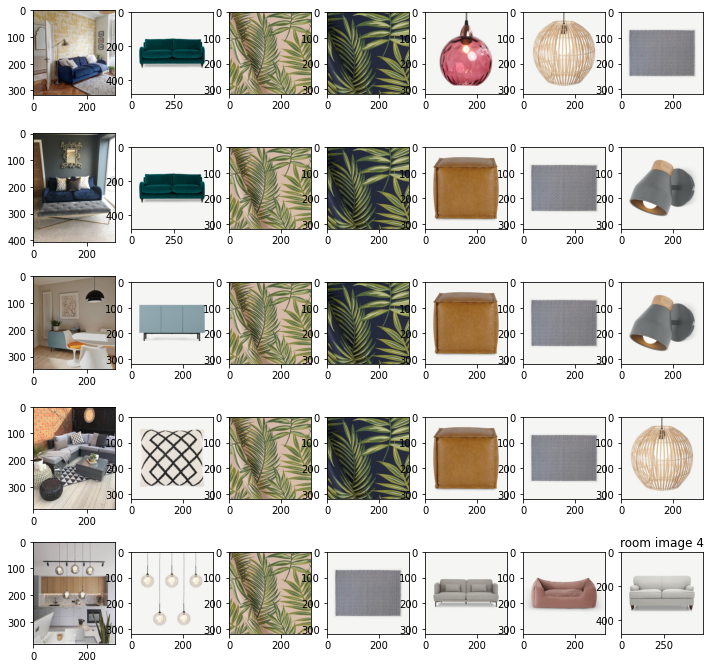

In [42]:
num_of_image = 5
num_of_KNN = 5
f, axarr = plt.subplots(num_of_image,num_of_KNN+2, figsize=(12, 12))
print("room, correct obj, top {} objects".format(num_of_KNN))
for i in range(num_of_image):
    room_im = Image.open(test_room_ds[i])
    plt.title("room image {}".format(i))
    axarr[i,0].imshow(room_im)
    dist_arr =  embededed_obj - embededed_room[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[:num_of_KNN]
    co = dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])]
    axarr[i,1].imshow(Image.open("test_obj/{}.jpg".format(co)))
    j = 2 
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
    
        item_im = Image.open(item_i)
        axarr[i, j].imshow(item_im)
        j+=1
plt.show()

### Result with pure embedding

Result of pure autoencoder projecting does not have a good accuracy. Random projection has a higher accuracy than predicted images. Potential reason is since in the latent space, object and room images are in the differen space, as it's shown in the above, same images will be closest to all room images. 

Especially as it's shown in the above, the image with no white background is appeared at the prediction for all 5 images' KNN becasue since the object is most similar to all the rooms.

Potentially, getting rid of object images with colored background could improve the accuracy.

Also, potentially, adding dense layer with input of embedding of room image, and output of embeeding of object image, with loss functoin of distance between embeddings, could move object images in the similar space with room objects in the latent space.

### Add Dense Layer 

As I stated above, I added dense layer.

#### Find Embeddings of all training data and store as npy files

In [34]:
IMAGE_SIZE = 100
def image_to_activations(image_path_x):
    img = tf.io.read_file(image_path_x)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img= img/255
    return img, image_path_x

In [35]:
def data_to_enc(ds):
    activation_dataset = tf.data.Dataset.from_tensor_slices(ds)
    activation_dataset = activation_dataset.map(image_to_activations, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
    i = 0
    for img_batch, path_batch in activation_dataset:
        print(i)
        i+=1
        batch_features = autoencoder.encoder(img_batch)
        for bf, p in zip(batch_features, path_batch):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())  

In [36]:
data_to_enc(room_ds)
data_to_enc(obj_ds)
data_to_enc(test_room_ds)
data_to_enc(test_obj_ds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1


#### Get embeddings of all the files

In [37]:
def get_emb(ds):
    embedded = []
    for path in ds:
        activation = np.load(path+".npy")
        embedded.append(activation.reshape(1,-1))
    return embedded

In [39]:
embedded_room = get_emb(room_ds)
embedded_obj = get_emb(obj_ds)
embedded_test_room = get_emb(test_room_ds)
embedded_test_obj = get_emb(test_obj_ds)

In [40]:
embedded_room_1 = np.squeeze(np.array(embedded_room))
embedded_obj_1 = np.squeeze(np.array(embedded_obj))
embedded_test_room_1 = np.squeeze(np.array(embedded_test_room))
embedded_test_obj_1 = np.squeeze(np.array(embedded_test_obj))
print(embedded_obj_1.shape)

(100, 20000)


#### Create a Dataset

In [41]:
# From embedded room, and embedded_obj, i made a new embedded_obj_paired which has embeddings of paired objects
embedded_obj_paired = []
for i in range(len(embedded_room)):
    obj_num = int(dic_room_item[int(room_ds[i].split("/")[1].split(".")[0])] )
    emb_num = obj_ds.index("obj/{}.jpg".format(obj_num))
    embedded_obj_paired.append(embedded_obj_1[emb_num])
embedded_obj_paired_1 =np.squeeze(np.array(embedded_obj_paired))

In [42]:
print(embedded_obj_paired_1.shape)

(1144, 20000)


In [43]:
# Repeated for test 
embedded_test_obj_paired = []
for i in range(len(embedded_test_room)):
    obj_num = int(dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] )
    emb_num = test_obj_ds.index("test_obj/{}.jpg".format(obj_num))
    embedded_test_obj_paired.append(embedded_test_obj_1[emb_num])
embedded_test_obj_paired_1 =np.array(embedded_test_obj_paired)
print(embedded_test_obj_paired_1.shape)

(570, 20000)


In [44]:
train_dataset = tf.data.Dataset.from_tensor_slices((embedded_room_1, embedded_obj_paired_1))
test_dataset = tf.data.Dataset.from_tensor_slices((embedded_test_room_1,embedded_test_obj_paired_1))

In [45]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset1 = test_dataset.batch(BATCH_SIZE)

In [46]:
x,y = next(iter(train_dataset))
print(x.shape,y.shape)

(64, 20000) (64, 20000)


#### Dense Layer

input and output dimension needs to be same, since the loss functoin is the distance between two embeddings

In [47]:
emb = tf.keras.Sequential()
emb.add(tf.keras.layers.Dense(20000, activation='relu'))

emb.add(tf.keras.layers.Dense(1000, activation='relu'))
emb.add(tf.keras.layers.Dropout(0.2))
emb.add(tf.keras.layers.Dense(20000))
emb.compile(loss='mean_absolute_error', optimizer='adam')

#### Fit a model

In [48]:
history = emb.fit(train_dataset, validation_data=test_dataset1, epochs=30)

Epoch 1/30
18/18 [==============================] - 31s 2s/step - loss: 0.2378 - val_loss: 0.1909
Epoch 2/30
18/18 [==============================] - 29s 2s/step - loss: 0.1870 - val_loss: 0.1821
Epoch 3/30
18/18 [==============================] - 30s 2s/step - loss: 0.1786 - val_loss: 0.1742
Epoch 4/30
18/18 [==============================] - 30s 2s/step - loss: 0.1709 - val_loss: 0.1667
Epoch 5/30
18/18 [==============================] - 30s 2s/step - loss: 0.1637 - val_loss: 0.1598
Epoch 6/30
18/18 [==============================] - 29s 2s/step - loss: 0.1572 - val_loss: 0.1537
Epoch 7/30
18/18 [==============================] - 30s 2s/step - loss: 0.1513 - val_loss: 0.1480
Epoch 8/30
18/18 [==============================] - 30s 2s/step - loss: 0.1457 - val_loss: 0.1424
Epoch 9/30
18/18 [==============================] - 30s 2s/step - loss: 0.1402 - val_loss: 0.1371
Epoch 10/30
18/18 [==============================] - 30s 2s/step - loss: 0.1351 - val_loss: 0.1322
Epoch 11/30
18/18 [

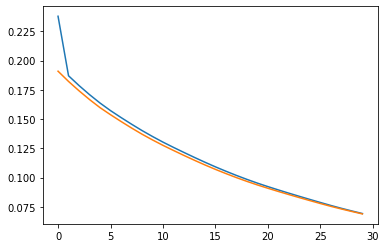

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#### Find Accuracy

In [50]:
test_dataset2 = test_dataset.batch(len(test_room_ds))

In [51]:
test_batch_x, test_batch_y = next(iter(test_dataset2))
# print(test_batch_x.shape)
predicted = emb(test_batch_x)

In [52]:
print(np.squeeze(np.array(embedded_test_obj)).shape)

(51, 20000)


In [53]:
encoded = np.vstack((np.array(predicted),embedded_test_obj_1))

In [54]:
print(encoded.shape)

(621, 20000)


In [55]:
print(len(test_obj_ds))

51


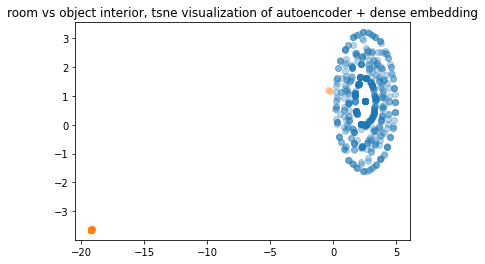

In [66]:
labels = [0] * len(predicted) + [1] * len(embedded_test_obj_1)
encoded1 = np.reshape(encoded,(encoded.shape[0],-1))
all_embedded = np.array(encoded1)
visualized = TSNE(n_components=2).fit_transform(all_embedded)
plt.title("room vs object interior, tsne visualization of autoencoder + dense embedding")
for label in np.unique(labels):
    plt.scatter(visualized[labels==label][:,0], visualized[labels==label][:,1], label=label, alpha=0.3)
plt.show()

In [90]:
correct = 0
# print(embededed_obj.shape)
knn = 10
for i in range(len(predicted)):
    dist_arr =  embedded_test_obj_1 - predicted[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  np.random.permutation(dist_arr.argsort())[:knn]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
    try:
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1
    except: 
        continue
            
print("correct images", correct)
print("accuracy of randomly selected {} images: {}".format(knn, correct/len(test_room_ds)))

correct images 109
accuracy of randomly selected 10 images: 0.1912280701754386


In [91]:
correct = 0
# print(embededed_obj.shape)
for i in range(len(predicted)):
    dist_arr =  embedded_test_obj_1 - predicted[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[:2]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
    try:
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1

    except: 
        continue
            
print("correct images", correct)
print("accuracy of recommended selected {} images: {}".format(knn, correct/len(test_room_ds)))

correct images 26
accuracy of recommended selected 10 images: 0.0456140350877193


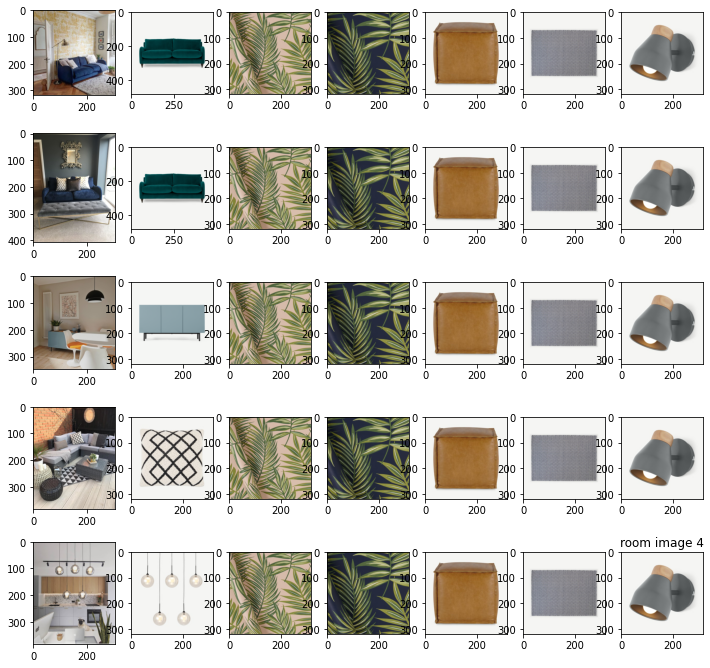

In [93]:
# correct = 0
num_of_image = 5
num_of_KNN = 5
f, axarr = plt.subplots(num_of_image,num_of_KNN+2, figsize=(12, 12))
for i in range(num_of_image):
    room_im = Image.open(test_room_ds[i])
    plt.title("room image {}".format(i))
    axarr[i,0].imshow(room_im)
    dist_arr =  embedded_test_obj_1 - predicted[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[:num_of_KNN]
    correct_index = dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])]

    axarr[i,1].imshow(Image.open("test_obj/{}.jpg".format(correct_index)))
    j = 2
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
        item_im = Image.open(item_i)
        axarr[i,j].imshow(item_im)
        j+=1
    if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1
#     except: 
#         continu
plt.show()


Since loss is going down, I summarized this requires more training epochs. However, since it's exhausting memory, I decided to stop the experiment here.

# Here we implement the variational autoencoder
Implementation framework borrowed from 
https://blog.keras.io/building-autoencoders-in-keras.html


### Build a VAE

In [94]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        z_mean = tf.cast(z_mean, tf.float32)
        z_log_var = tf.cast(z_log_var, tf.float32)
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
# class extract_style_and_flatten(layers.Layer):
    
#     def call(self, inputs):
#         for layer in 

#### Encoder


In [95]:
latent_dim = 300
IMAGE_SIZE =224

encoder_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
# x= middle_cut(encoder_inputs)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu", dtype="float32")(x)
z_mean = layers.Dense(latent_dim, name="z_mean", dtype="float32")(x)

# someone on the internet said if u initialize this to all 0s you can avoid exploding gradient
z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer='zeros',dtype="float32")(x)
z = Sampling()((z_mean, z_log_var))
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 112, 112, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 56, 56, 64)   18496       conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 28, 28, 128)  73856       conv2d_16[0][0]                  
____________________________________________________________________________________________

#### Decoder

In [96]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 512, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 512))(x)
x = layers.Conv2DTranspose(512, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)


decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same", dtype="float32")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 25088)             7551488   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 256)       1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 112, 112, 64)      7379

#### Putting it all together

In [97]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            data = layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE)
            print(data.shape)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 224 * 224
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [98]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [113]:
# Since he already trained a morel, we just load the weights
vae.load_weights("chkpt4")

### Test Accuracy 

#### Data Preproecess, Make Dataset

In [100]:
#read each image and convert them to tesnorflow vectors
#Since it's autoencoder, input and output are both images
IMAGE_SIZE = 224
def image_to_activations(image_path_x, image_path_y):
    img = tf.io.read_file(image_path_x)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img= img/255
    return img, img

In [101]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_x))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_x))

In [102]:
train_dataset = train_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)
map_test_dataset = test_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [103]:
map_test_dataset = map_test_dataset.batch(len(map_test_dataset))

#### Get Embeddings

In [114]:
x,y = next(iter(map_test_dataset))
# Since Vae encoder gives a result of mean, std, and embeddings
predicted = vae.encoder(x)[2]

In [106]:
predicted = np.array(predicted)
print(predicted.shape)

(621, 300)


In [107]:
print(len(test_room_ds), len(test_obj_ds))

570 51


In [108]:
embedded_test_obj_np = predicted[len(test_room_ds):]
predicted = predicted[:len(test_room_ds)]


In [109]:
print(embedded_test_obj_np.shape, predicted.shape)

(51, 300) (570, 300)


#### 10 Random Recommendation Accuracy

In [110]:
correct = 0
# print(embededed_obj.shape)
for i in range(len(predicted)):
    dist_arr =  embedded_test_obj_np - predicted[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  np.random.permutation(dist_arr.argsort())[:10]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
    try:
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1

    except: 
        continue
            
print("correct images", correct)
print("accuracy of randomly selected {} images: {}".format(knn, correct/len(test_room_ds)))

correct images 104
accuracy of recommended selected 10 images: 0.1824561403508772


#### VAE top 10 recommendation accuracy

In [111]:
correct = 0
# print(embededed_obj.shape)
for i in range(len(predicted)):
    dist_arr =  embedded_test_obj_np - predicted[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[:10]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
    try:
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1

    except: 
        continue
            
print("correct images", correct)
print("accuracy of recommended selected {} images: {}".format(knn, correct/len(test_room_ds)))

correct images 109
accuracy of recommended selected 10 images: 0.1912280701754386


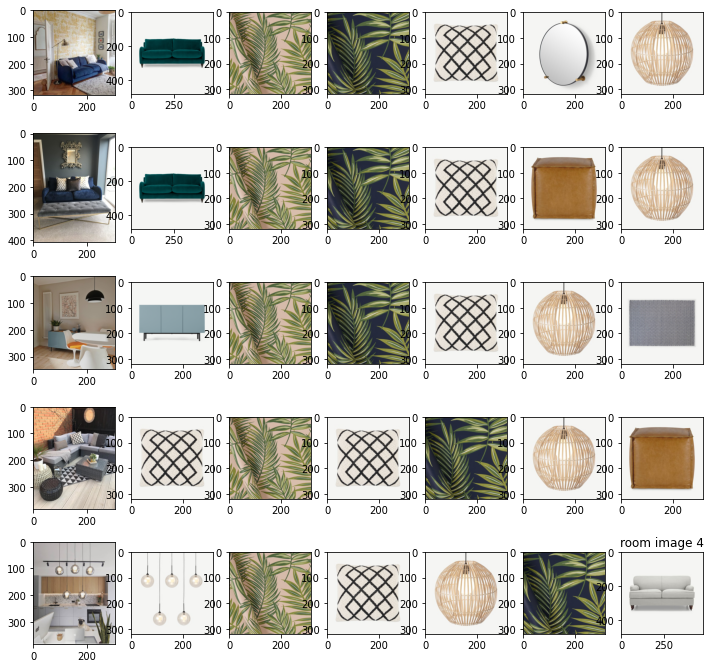

In [112]:
# correct = 0
num_of_image = 5
num_of_KNN = 5
f, axarr = plt.subplots(num_of_image,num_of_KNN+2, figsize=(12, 12))
for i in range(num_of_image):
    room_im = Image.open(test_room_ds[i])
    plt.title("room image {}".format(i))
    axarr[i,0].imshow(room_im)
    dist_arr =  embedded_test_obj_np - predicted[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[:num_of_KNN]
    correct_index = dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])]

    axarr[i,1].imshow(Image.open("test_obj/{}.jpg".format(correct_index)))
    j = 2
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
        item_im = Image.open(item_i)
        axarr[i,j].imshow(item_im)
        j+=1
    if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1
#     except: 
#         continu
plt.show()

### Summary (VAE)

As we can see, we have the same problems from AE. The top recommendaionts are objects without the white backgrounds. 
The accuracy sometimes worse than random recommendations due to room and objected projected different space.

## VGG 19 Style Extractor

Now move on to t a new method VGG19 Embedding. 

Inspired from  style transfer learning, we used vgg16 to capture styles of images. Using outputs of style layers from vgg16, we calculate gram matrix which will capture style components, and make a long embedding after caluclation of gram matrix. Using the embeddings, we tried several methods. 

First, since the embedding is large, we try to shrink the datasize. (Please refer to the experiment file)

1) PCA 

2) Random Projection 
After the work, we found PCA does not work since PCA requrie all the images embedding. Random projection works to shrink the dataset size to the smaller size.

Based on shrinked size embeddings,first I check whether the styles are clustered. Then, I wrote a code to test accuracy as well as some potentia improvement methods by Room->Room&Obj->Obj and adding a dense layer.

### Style extractor


In [57]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [58]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [59]:
style_extractor = vgg_layers(style_layers)

In [60]:
def gram_matrix(input_tensor):
    tf.cast(input_tensor, tf.float32)
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [61]:
IMAGE_SIZE = 244
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3))
styleoutputs = style_extractor(inputs)
styleoutputs = [gram_matrix(style) for style in styleoutputs]
styleoutputs = [tf.keras.layers.Flatten()(style) for style in styleoutputs]
result = tf.concat(styleoutputs, axis = 1)
extractor = tf.keras.Model(inputs, result, name="style_extract")

#### Data into VGG

In [115]:

#Get all filepaths from each directory
japanese_files = list(glob.glob("./japanese_interior/*.jpg"))
modern_files = list(glob.glob("./modern_interior/*.jpg"))
scandinavian_files = list(glob.glob("./scandinavian_interior/*.jpg"))
#Make training and test dataset

In [62]:
IMAGE_SIZE = 244
def image_to_activations(image_path):
#     print(image_path[0])
    img = tf.io.read_file(image_path)
#     print(type(img))
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    activations = tf.keras.applications.vgg19.preprocess_input(img)
    return activations, image_path

In [63]:
def activation_to_emb(ds):
    activation_dataset = tf.data.Dataset.from_tensor_slices(ds)
    activation_dataset = activation_dataset.map(image_to_activations,  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
    i = 0
# Save all activations to disk in NumPy format
    for img_batch, path_batch in activation_dataset:
        print(i)
        i+=1
        batch_features = extractor(img_batch)
        for bf, p in zip(batch_features, path_batch):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())  

In [10]:
activation_to_emb(japanese_files)
activation_to_emb(modern_files)
activation_to_emb(scandinavian_files)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [64]:
room_ds = list(glob.glob("room/*.jpg"))
obj_ds = list(glob.glob("obj/*.jpg"))
test_room_ds = list(glob.glob("test_room/*.jpg"))
test_obj_ds = list(glob.glob("test_obj/*.jpg"))

In [65]:
activation_to_emb(room_ds)
activation_to_emb(obj_ds)
activation_to_emb(test_room_ds)
activation_to_emb(test_obj_ds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1


### Random Projection

In [67]:
johnson_lindenstrauss_min_dim(n_samples = 1000, eps=0.5)

331

In [68]:
grp = GaussianRandomProjection(n_components=500).fit(np.zeros((1000, extractor.layers[-1].output_shape[0][1])))

In [69]:
def get_emb(ds):
    embedded = []
    for path in ds:
        activation = np.load(path+".npy")
        embedded.append(grp.transform(activation.reshape(1,-1)))
    return embedded

In [70]:
embedded_room = get_emb(room_ds)
embedded_obj = get_emb(obj_ds)
embedded_test_room = get_emb(test_room_ds)
embedded_test_obj = get_emb(test_obj_ds)

### CHeck if different styles are captured 

In [17]:
# MY Code Here
embedded_japanese = get_emb(japanese_files)
embedded_modern = get_emb(modern_files)
embedded_scandinavian= get_emb(scandinavian_files)

In [18]:
all_embedded = np.vstack((np.squeeze(np.array(embedded_japanese)),np.squeeze(np.array(embedded_modern)), np.squeeze(np.array(embedded_scandinavian))))

In [23]:
labels = [0] * len(embedded_japanese) + [1] * len(embedded_modern) + [2]*len(embedded_scandinavian) 

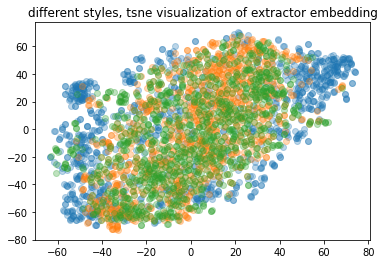

In [24]:
all_embedded = np.array(all_embedded)
all_embedded = all_embedded.squeeze()
visualized = TSNE(n_components=2).fit_transform(all_embedded)
plt.title("different styles, tsne visualization of extractor embedding")
for label in np.unique(labels):
    plt.scatter(visualized[labels==label][:,0], visualized[labels==label][:,1], label=label, alpha=0.3)
plt.show()

Blue is Japanese, Orange is Modern, and green is Scandinavian interior 

Different Style are not really captured, but I could see some japanese rooms are projected in the different space than modern and scandinavian rooms. Since modern and scandinavian rooms are resemble, it is no surprise that thay are clustered simialr spaces. 

### Testing Recommendation's accuracy (Pure VGG19 Style Extractor + Random Projection)

#### Check if room and objects are projected similar spaces or not

In [15]:
all_embedded = np.vstack((np.squeeze(np.array(embedded_room)),np.squeeze(np.array(embedded_obj)), np.squeeze(np.array(embedded_test_room)), np.squeeze(np.array(embedded_test_obj))))

In [16]:
labels = [0] * len(embedded_room) + [1] * len(embedded_obj) + [2]*len(embedded_test_room) + [3]*len(embedded_test_obj)

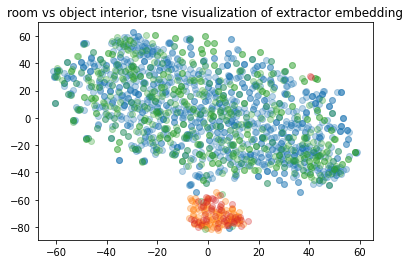

In [17]:
all_embedded = np.array(all_embedded)
all_embedded = all_embedded.squeeze()
visualized = TSNE(n_components=2).fit_transform(all_embedded)
plt.title("room vs object interior, tsne visualization of extractor embedding")
for label in np.unique(labels):
    plt.scatter(visualized[labels==label][:,0], visualized[labels==label][:,1], label=label, alpha=0.3)
plt.show()

VGG19 Style Extractor has the same problem as AE and VAE that objects and rooms are projected in the differnt spaces. 

In [71]:
embedded_test_obj1 = np.squeeze(np.array(embedded_test_obj))
embedded_test_room1 = np.squeeze(np.array(embedded_test_room))
embedded_obj1 = np.squeeze(np.array(embedded_obj))
embedded_room1 = np.squeeze(np.array(embedded_room))
print(embedded_test_obj1.shape)
print(embedded_test_room1.shape)

(51, 500)
(570, 500)


#### Purly find KNN objects

#### Random 10 recommendations accuracy


In [43]:
correct = 0
knn = 10
# print(embededed_obj.shape)
for i in range(embedded_test_room1.shape[0]):
    dist_arr =  embedded_test_obj1 - embedded_test_room1[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  np.random.permutation(dist_arr.argsort())[:knn]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
    try:
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1
    except: 
        continue         
print("correct images", correct)
print("accuracy of randomly selected {} images: {}".format(knn, correct/len(embedded_test_room1)))

correct images 102
accuracy of randomly selected 10 images: 0.17894736842105263


#### VGG19 + Random Projection  Top 10 recommendations accuracy 

In [44]:
correct = 0
# print(embededed_obj.shape)
for i in range(embedded_test_room1.shape[0]):
    dist_arr =  embedded_test_obj1 - embedded_test_room1[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[:knn]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
    try:
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1
    except: 
        continue
            
print("correct images", correct)
print("accuracy of KNN predicted {} images: {}".format(knn, correct/len(embedded_test_room1)))

correct images 170
accuracy of KNN predicted 10 images: 0.2982456140350877


### Room --> Closest Room and Closest Rooms' Paired Object --> KNN Object

#### Random 10 recommendations accuracy 

In [45]:
correct = 0
for i in range(len(embedded_test_room)):
    dist_arr =  embedded_room1 - embedded_test_room1[i]
#     dist_arr = np.linalg.norm(dist_arr, axis=1)
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  np.random.permutation(dist_arr.argsort())[:1]
    for j in smallest_idxs: 
        item_i = dic_room_item[int(room_ds[j].split("/")[1].split(".")[0])]
        item_i = obj_ds.index("obj/{}.jpg".format(item_i))
        dist_arr2 =  embedded_test_obj1 - embedded_obj1[item_i]
#         dist_arr2 = np.linalg.norm(dist_arr2, axis=1)
        dist_arr2 = np.linalg.norm(dist_arr2, axis=1)
        smallest_idxs =  np.random.permutation(dist_arr2.argsort())[:knn]
        correct_idxs = []
        for idx in smallest_idxs:
            item_i = test_obj_ds[idx]
            correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1
            
print("correct images", correct)
print("accuracy of randomly selected {} images: {}".format(knn, correct/len(embedded_test_room1)))

correct images 104
accuracy of randomly selected 10 images: 0.1824561403508772


#### VGG19 + Random Projection + Room->Room Obj->Obj Top 10 recommendations accuracy 

In [47]:
correct = 0
for i in range(len(embedded_test_room)):
    dist_arr =  embedded_room1 - embedded_test_room1[i]
#     dist_arr = np.linalg.norm(dist_arr, axis=1)
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[:1]
    for j in smallest_idxs: 
        item_i = dic_room_item[int(room_ds[j].split("/")[1].split(".")[0])]
        item_i = obj_ds.index("obj/{}.jpg".format(item_i))
        dist_arr2 =  embedded_test_obj1 - embedded_obj1[item_i]
#         dist_arr2 = np.linalg.norm(dist_arr2, axis=1)
        dist_arr2 = np.linalg.norm(dist_arr2, axis=1)
        smallest_idxs =  dist_arr2.argsort()[:knn]
        correct_idxs = []
        for idx in smallest_idxs:
            item_i = test_obj_ds[idx]
            correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1
            
print("correct images", correct)
print("accuracy of recommended {} images: {}".format(knn, correct/len(embedded_test_room1)))

correct images 191
accuracy of recommended 10 images: 0.3350877192982456


room, correct obj, KNN objects


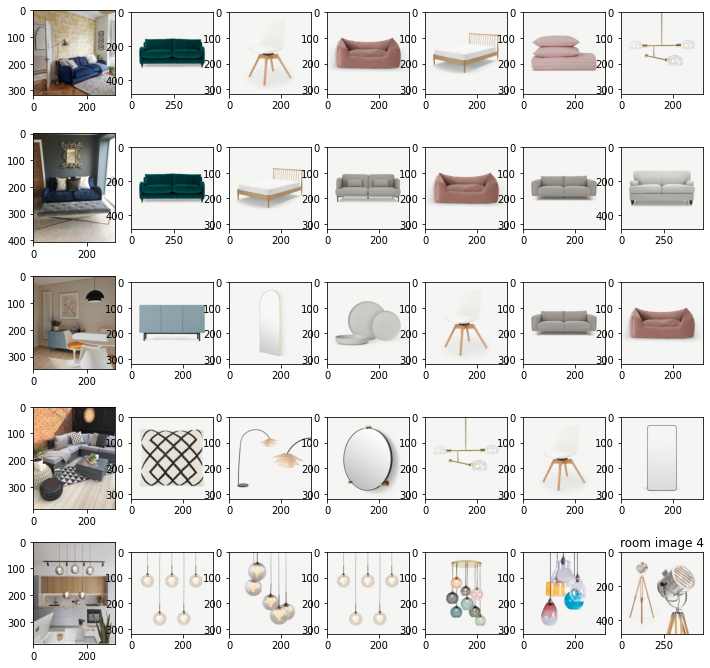

In [48]:
correct = 0

num_of_image = 5
num_of_KNN = 5
f, axarr = plt.subplots(num_of_image,num_of_KNN+2, figsize=(12, 12))
for i in range(num_of_image):
    room_im = Image.open(test_room_ds[i])
    plt.title("room image {}".format(i))
    axarr[i,0].imshow(room_im)
   
    dist_arr =  embedded_room - embedded_test_room[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[1]
    co = dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])]
    axarr[i,1].imshow(Image.open("test_obj/{}.jpg".format(co)))
    j = 2 
    
    item_i = dic_room_item[int(room_ds[smallest_idxs].split("/")[1].split(".")[0])]
    item_i = obj_ds.index("obj/{}.jpg".format(item_i))
    dist_arr2 =  embedded_test_obj - embedded_obj[item_i]

    dist_arr2 = np.linalg.norm(dist_arr2, axis=1)
    dist_arr2 = np.linalg.norm(dist_arr2, axis=1)
    smallest_idxs =  dist_arr2.argsort()[:num_of_KNN]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
        item_im = Image.open(item_i)
        axarr[i, j].imshow(item_im)
        j +=1
        
print("room, correct obj, KNN objects")
plt.show()


### Add Dense Layer

#### Dense Layer Model

In [72]:
emb = tf.keras.Sequential()
emb.add(tf.keras.layers.Dense(500, activation='relu'))

emb.add(tf.keras.layers.Dense(256, activation='relu'))
emb.add(tf.keras.layers.Dropout(0.2))
emb.add(tf.keras.layers.Dense(500))
emb.compile(loss='mean_absolute_error', optimizer='adam')

#### Make a datasets, so each embedded room has a correct paired embedded obj as output

In [73]:
embedded_obj_paired = []
for i in range(embedded_room1.shape[0]):
    obj_num = int(dic_room_item[int(room_ds[i].split("/")[1].split(".")[0])] )
    emb_num = obj_ds.index("obj/{}.jpg".format(obj_num))
    embedded_obj_paired.append(embedded_obj1[emb_num])

In [74]:
embedded_test_obj_paired = []
for i in range(len(embedded_test_room)):
    obj_num = int(dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] )
    emb_num = test_obj_ds.index("test_obj/{}.jpg".format(obj_num))
    embedded_test_obj_paired.append(embedded_test_obj1[emb_num])
# embedded_test_room =np.squeeze(embedded_test_room)

In [75]:
print(embedded_room1.shape)
print(np.array(embedded_obj_paired).shape)
print(np.array(embedded_test_obj_paired).shape)
print(embedded_test_room1.shape)

(1144, 500)
(1144, 500)
(570, 500)
(570, 500)


In [76]:
train_dataset = tf.data.Dataset.from_tensor_slices((embedded_room1, np.array(embedded_obj_paired)))
test_dataset = tf.data.Dataset.from_tensor_slices((embedded_test_room1,np.array(embedded_test_obj_paired)))

In [77]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset1 = test_dataset.batch(BATCH_SIZE)

In [78]:
x,y = next(iter(test_dataset1))
print(x.shape,y.shape)

(64, 500) (64, 500)


#### Fit the model

In [33]:
history = emb.fit(train_dataset, validation_data=test_dataset1, epochs=30)

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 0s 9ms/step - loss: 3789927.0000 - val_loss: 2708931.2500
Epoch 2/30
18/18 [==============================] - 0s 5ms/step - loss: 2713953.2500 - val_loss: 2502982.2500
Epoch 3/30
18/18 [==============================] - 0s 6ms/step - loss: 2537006.0000 - val_loss: 2488652.0000
Epoch 4/30
18/18 [==============================] - 0s 5ms/step - loss: 2465102.5000 - val_loss: 2449064.0000
Epoch 5/30
18/18 [==============================] - 0s 5ms/step - lo

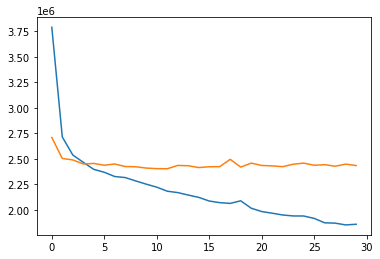

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Since it starts to overfit after 3 epochs, we decided to have only 3 epochs. 

In [79]:
emb = tf.keras.Sequential()
emb.add(tf.keras.layers.Dense(500, activation='relu'))

emb.add(tf.keras.layers.Dense(256, activation='relu'))
emb.add(tf.keras.layers.Dropout(0.2))
emb.add(tf.keras.layers.Dense(500))
emb.compile(loss='mean_absolute_error', optimizer='adam')
history = emb.fit(train_dataset, validation_data=test_dataset1, epochs=3)

Epoch 1/3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 0s 8ms/step - loss: 3796003.2500 - val_loss: 2684544.5000
Epoch 2/3
18/18 [==============================] - 0s 5ms/step - loss: 2654499.5000 - val_loss: 2469679.0000
Epoch 3/3
18/18 [==============================] - 0s 5ms/step - loss: 2473690.7500 - val_loss: 2445028.2500


### Get a embeddings using test set

In [80]:
test_dataset2 = test_dataset.batch(len(test_room_ds))

In [81]:
test_batch_x, test_batch_y = next(iter(test_dataset2))
print(test_batch_x.shape)
predicted = emb(test_batch_x)

(570, 500)


#### Show Latent space after the dense layer

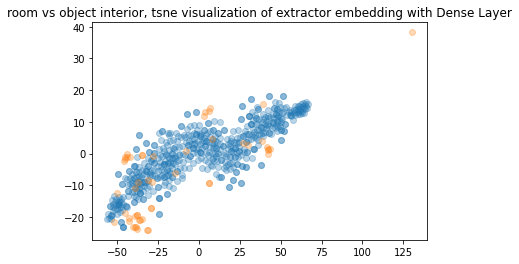

In [83]:
labels = [0] * len(predicted) + [1] * len(embedded_test_obj1) 
encoded = np.vstack((predicted,embedded_test_obj1))
encoded1 = np.reshape(encoded,(encoded.shape[0],-1))
all_embedded = np.array(encoded1)
visualized = TSNE(n_components=2).fit_transform(all_embedded)
plt.title("room vs object interior, tsne visualization of extractor embedding with Dense Layer")
for label in np.unique(labels):
    plt.scatter(visualized[labels==label][:,0], visualized[labels==label][:,1], label=label, alpha=0.3)
plt.show()

It does seems like object and room are aligned in the simialr spaces. 

### Get Accuracy 

#### Random 10 images accuracy

In [39]:
correct = 0
knn = 10
# print(embededed_obj.shape)
for i in range(len(predicted)):
    dist_arr =  embedded_test_obj1 - predicted[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  np.random.permutation(dist_arr.argsort())[:knn]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
    try:
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1
    except: 
        continue
            
print("correct images", correct)
print("accuracy of random {} images: {}".format(knn, correct/len(test_room_ds)))

correct images 105
accuracy of random 10 images: 0.18421052631578946


#### VGG19 + Random Projection + Dense Top 10 recommendations accuracy 

In [40]:
correct = 0
# print(embededed_obj.shape)
for i in range(len(predicted)):
    dist_arr =  embedded_test_obj1 - predicted[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[:knn]
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
    try:
        if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1
            room_im = Image.open(test_room_ds[i])
    except: 
        continue
            
print("correct images", correct)
print("accuracy of recommended {} images: {}".format(knn, correct/len(embedded_test_room1)))

correct images 163
accuracy of recommended 10 images: 0.28596491228070176


room, paired obj, recommenadtions


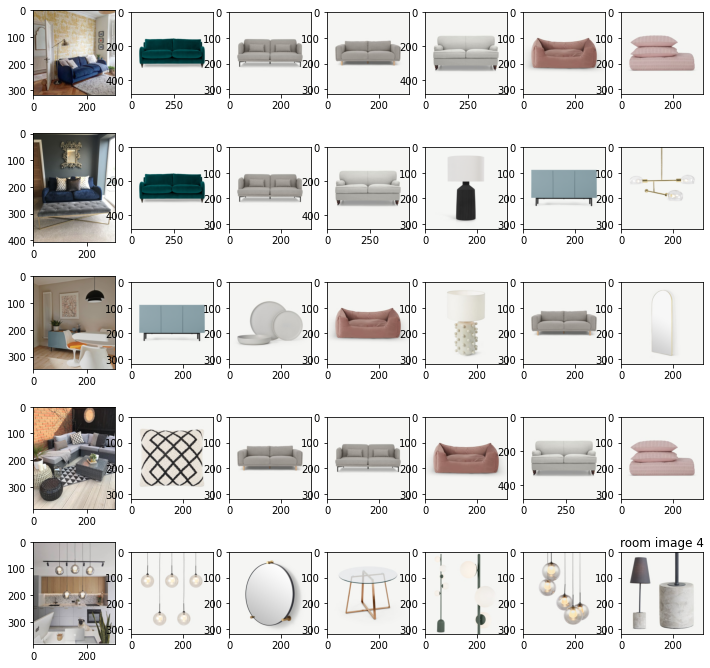

In [42]:
correct = 0
num_of_image = 5
knn = 5
f, axarr = plt.subplots(num_of_image,knn+2, figsize=(12, 12))

for i in range(num_of_image):
    room_im = Image.open(test_room_ds[i])
    plt.title("room image {}".format(i))
    axarr[i,0].imshow(room_im)

    dist_arr =  embedded_test_obj_np - predicted[i]
    dist_arr = np.linalg.norm(dist_arr, axis=1)
    smallest_idxs =  dist_arr.argsort()[:knn]
    correct_index = dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])]
    axarr[i,1].imshow(Image.open("test_obj/{}.jpg".format(correct_index)))
#     try:
    j = 2
    correct_idxs = []
    for idx in smallest_idxs:
        item_i = test_obj_ds[idx]
        correct_idxs.append(int(item_i.split("/")[1].split(".")[0]))
        item_im = Image.open(item_i)
        axarr[i,j].imshow(item_im)
        j+=1
    if dic_room_item[int(test_room_ds[i].split("/")[1].split(".")[0])] in correct_idxs:
            correct +=1
#     except: 
#         continue
print("room, paired obj, recommenadtions")
plt.show()
